In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error


In [37]:
# Load CSV
simData = pd.read_csv("data/solar_system_data - Copy.csv")

# Clean missing values FIRST
simData = simData.dropna()

# Now split clean data
# Training on data from 1/1/2000 to 12/31/2001
train_data = simData[simData['Date'] <= '12/31/2001']

# Future data to predict: January and February 2002
future_data = simData[(simData['Date'] >= '1/1/2002') & (simData['Date'] <= '2/28/2002')]

# View first few rows if you want
simData.head()


,Date,Earth_x,Earth_y,Mars_x,Mars_y,Venus_x,Venus_y,Mercury_x,Mercury_y
0,1/1/2000,-0.168563,0.968761,1.390360,-0.020998,-0.718629,-0.022519,-0.140712,-0.443906
1,1/2/2000,-0.185788,0.965592,1.391033,-0.005792,-0.717829,-0.042839,-0.119321,-0.450359
2,1/3/2000,-0.202954,0.962123,1.391551,0.009415,-0.716459,-0.063125,-0.097581,-0.455498
3,1/4/2000,-0.220058,0.958353,1.391917,0.024621,-0.714521,-0.083361,-0.075556,-0.459306
4,1/5/2000,-0.237092,0.954283,1.392130,0.039824,-0.712015,-0.103531,-0.053311,-0.461772


In [38]:
# Create features and target variables
# Features: time, x, y
# Time is the independent variable, and x and y are the dependent variables
time = simData[['Date']]
x_target = simData['Earth_x']
y_target = simData['Earth_y']

In [39]:
# Stack x and y into a feature matrix
features = simData[['Earth_x', 'Earth_y']].values
print(np.isnan(features).sum())  # Check for NaN values

0


In [40]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)


In [41]:
# Create a sequence of data points for LSTM input
def create_sequences(data, sequence_length=30):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Create input/output
X, y = create_sequences(scaled_features)


In [42]:
# Assume we already dropped Jan 2002 from the CSV
split_index = len(X)  # train on all available


In [43]:

X_train = X
y_train = y

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2))  # 2 outputs: x and y coordinates

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


c:\Users\edmar\OneDrive\Documents\CSUF\Machine Learning\Solar-System-Dyamics\ofile\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1605 
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6153e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1748e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5962e-05
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8495e-05
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6282e-05
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6990e-05
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1442e-05
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7577e-05
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5096e-05
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3362e-05
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2212e-05
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

In [44]:
# Scale future data (January + February 2002) using the same scaler
future_features = scaler.transform(future_data[['Earth_x', 'Earth_y']].values)

# Create sequences for future prediction
X_future, _ = create_sequences(future_features, sequence_length=30)

# Predict with the trained model
predictions = model.predict(X_future)

# Inverse transform predictions to get back original AU scale
predictions_unscaled = scaler.inverse_transform(predictions)

# Extract true values for comparison
true_x = future_data['Earth_x'].values[30:]  # offset by 30 days because of sequence length
true_y = future_data['Earth_y'].values[30:]

predicted_x = predictions_unscaled[:, 0]
predicted_y = predictions_unscaled[:, 1]

# model = Sequential()
# model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(2))  # 2 outputs: x and y

# model.compile(optimizer='adam', loss='mse')
# model.fit(X_train, y_train, epochs=50, batch_size=32)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


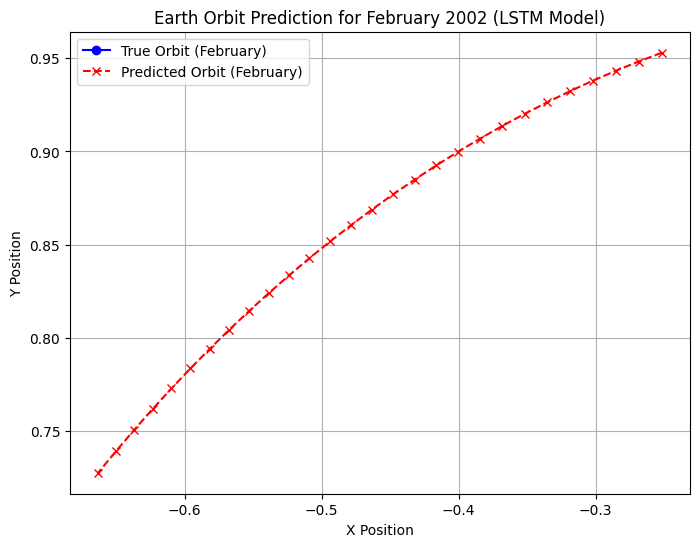

In [45]:
# Predict the next 28 days (Feb 1 - Feb 28, 2002)
# Generate predictions
# Use the last 30 days of training data to predict the next 28 days

predictions = model.predict(X_train[-28:])

# Unscale the predictions back to real coordinates
# Remember we scaled both x and y together earlier
predictions_unscaled = scaler.inverse_transform(predictions)

# Load the real February 2002 data
true_data = pd.read_csv("data/solar_system_data.csv")

# Filter only Feb 1–28

feb_data = true_data[(true_data['Date'] >= '2/1/2002') & (true_data['Date'] <= '2/28/2002')]

# 4. Plot results
plt.figure(figsize=(8,6))
plt.plot(feb_data['Earth_x'], feb_data['Earth_y'], 'o-', label="True Orbit (February)", color='blue')
plt.plot(predictions_unscaled[:,0], predictions_unscaled[:,1], 'x--', label="Predicted Orbit (February)", color='red')
plt.title('Earth Orbit Prediction for February 2002 (LSTM Model)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\edmar\AppData\Local\Temp\ipykernel_32440\1313154735.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


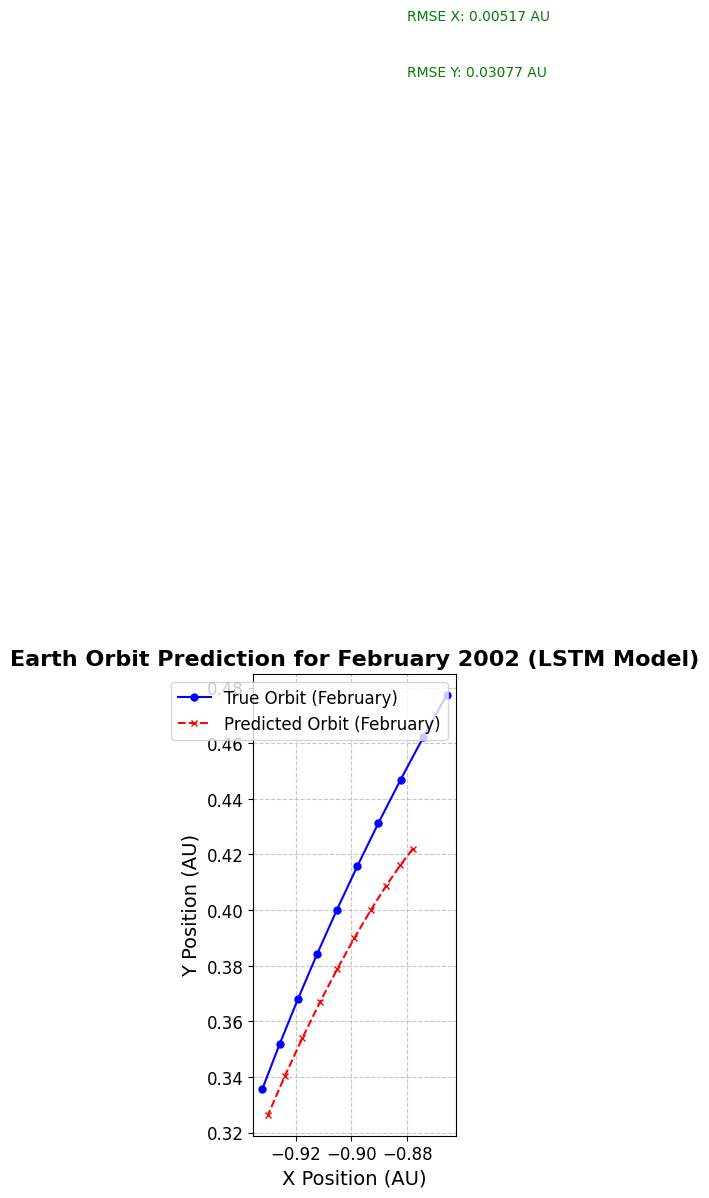

In [48]:
# Filter February 2002 data
february_data = simData[(simData['Date'] >= '2/1/2002') & (simData['Date'] <= '2/28/2002')]
# Scale February input data using the *same* scaler
february_features = scaler.transform(february_data[['Earth_x', 'Earth_y']].values)

# Create sequences for the model
X_february, _ = create_sequences(february_features, sequence_length=30)

# Predict
# Predict
predictions = model.predict(X_february)

# Inverse transform predictions to original scale
predictions_unscaled = scaler.inverse_transform(predictions)

# Get true and predicted coordinates
true_x = february_data['Earth_x'].values[30:]
true_y = february_data['Earth_y'].values[30:]
predicted_x = predictions_unscaled[:, 0]
predicted_y = predictions_unscaled[:, 1]
# 
mse_x = mean_squared_error(true_x, predicted_x)
mse_y = mean_squared_error(true_y, predicted_y)

rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot true orbit (blue solid line + dots)
ax.plot(true_x, true_y, color='blue', marker='o', linestyle='-', label='True Orbit (February)', markersize=5)

# Plot predicted orbit (red dashed line + x marks)
ax.plot(predicted_x, predicted_y, color='red', linestyle='--', marker='x', label='Predicted Orbit (February)', markersize=5)

# Title and labels
ax.set_title('Earth Orbit Prediction for February 2002 (LSTM Model)', fontsize=16, weight='bold')
ax.set_xlabel('X Position (AU)', fontsize=14)
ax.set_ylabel('Y Position (AU)', fontsize=14)

# Grid and legend
ax.grid(True, which='both', linestyle='--', alpha=0.7)
ax.legend(fontsize=12, loc='best')

# Make sure axis are square
ax.set_aspect('equal')

# Bigger ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# 
ax.text(-0.88, 0.72, f"RMSE X: {rmse_x:.5f} AU", fontsize=10, color='green')
ax.text(-0.88, 0.70, f"RMSE Y: {rmse_y:.5f} AU", fontsize=10, color='green')

# Tight layout
plt.tight_layout()

# Show the figure
plt.show()
# Add RMSE text to plot


In [16]:
# Get the last 30 days from the end of training data
last_known_data = simData[(simData['Date'] >= '1/2/2002') & (simData['Date'] <= '1/31/2002')]
last_known_features = scaler.transform(last_known_data[['Earth_x', 'Earth_y']].values)

# Make sure it’s the right shape
print(last_known_features.shape)  # Should be (30, 2)



(40, 2)


In [121]:
# Initialize
current_sequence = last_known_features
predicted_orbit = []

# Predict day by day
for day in range(365):  # Simulate a full year
    pred = model.predict(current_sequence[np.newaxis, :, :])  # Predict next day
    predicted_orbit.append(pred[0])  # Save prediction
    
    # Update the sequence (slide the window)
    current_sequence = np.vstack([current_sequence[1:], pred])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

In [122]:
# Convert list to array
predicted_orbit = np.array(predicted_orbit)

# Inverse scale the predictions
predicted_orbit_unscaled = scaler.inverse_transform(predicted_orbit)

# Split x and y
predicted_x_full = predicted_orbit_unscaled[:, 0]
predicted_y_full = predicted_orbit_unscaled[:, 1]


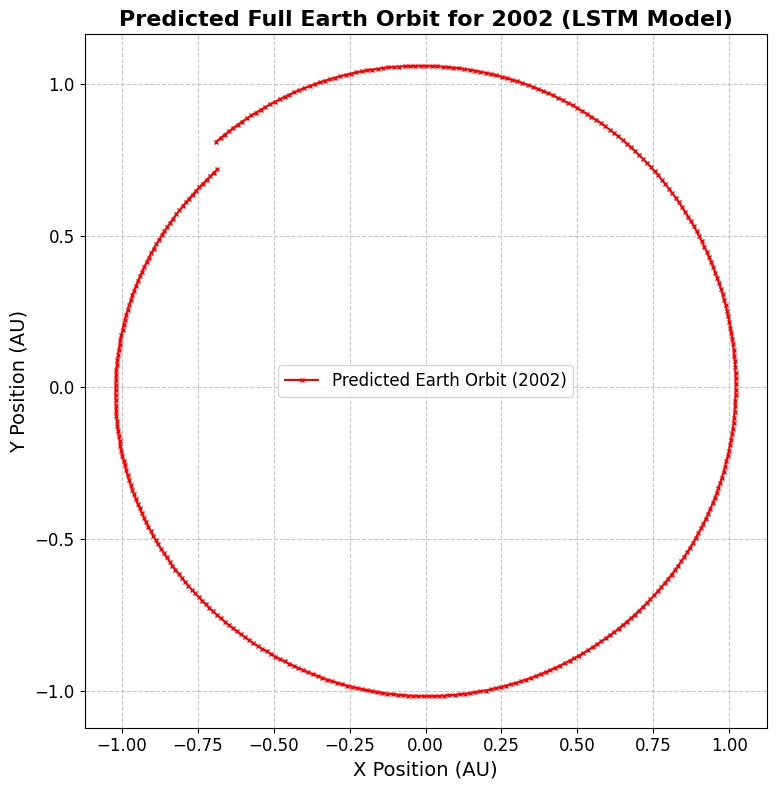

In [123]:
# Plot full orbit prediction
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(predicted_x_full, predicted_y_full, color='red', linestyle='-', marker='x', markersize=3, label='Predicted Earth Orbit (2002)')
ax.set_title('Predicted Full Earth Orbit for 2002 (LSTM Model)', fontsize=16, weight='bold')
ax.set_xlabel('X Position (AU)', fontsize=14)
ax.set_ylabel('Y Position (AU)', fontsize=14)

ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=12)
ax.set_aspect('equal')
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# # %matplotlib inline
# # %matplotlib notebook



MovieWriter imagemagick unavailable; using Pillow instead.


Animation saved as 'earth_orbit_prediction.gif'


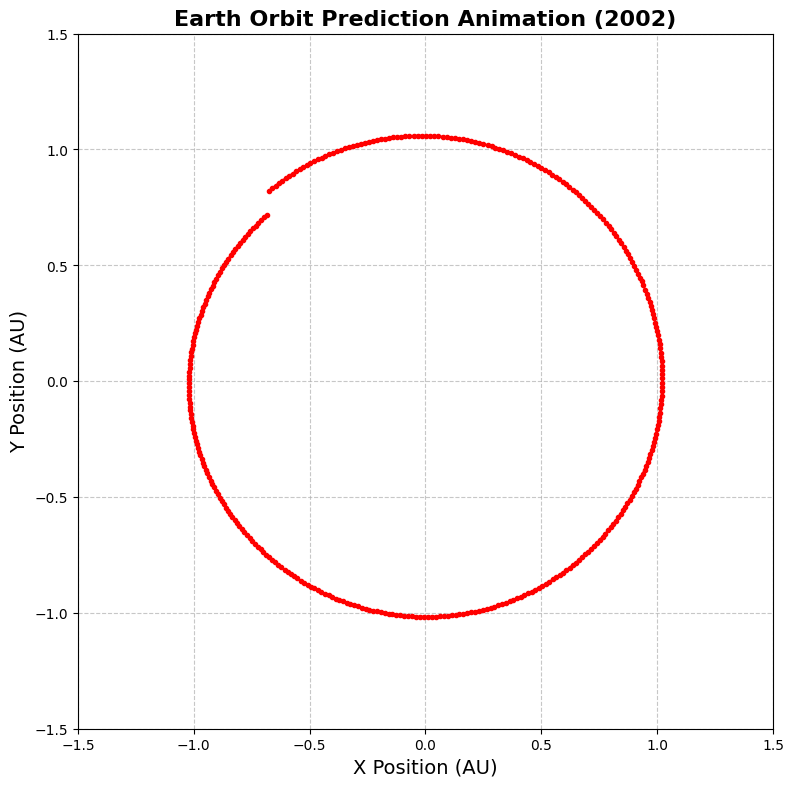

In [137]:
# import matplotlib.animation as animation
#---tried to animate the orbit but it was not working as expected---#


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlabel('X Position (AU)', fontsize=14)
ax.set_ylabel('Y Position (AU)', fontsize=14)
ax.set_title('Earth Orbit Prediction Animation (2002)', fontsize=16, weight='bold')

line, = ax.plot([], [], color='red', linestyle='-', marker='o', markersize=3)

def update(frame):
    line.set_data(predicted_x_full[:frame], predicted_y_full[:frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames=len(predicted_x_full), interval=30, blit=True)

ani.save('earth_orbit_prediction.gif', writer='imagemagick', fps=30)
print("Animation saved as 'earth_orbit_prediction.gif'")

plt.tight_layout()
plt.show()


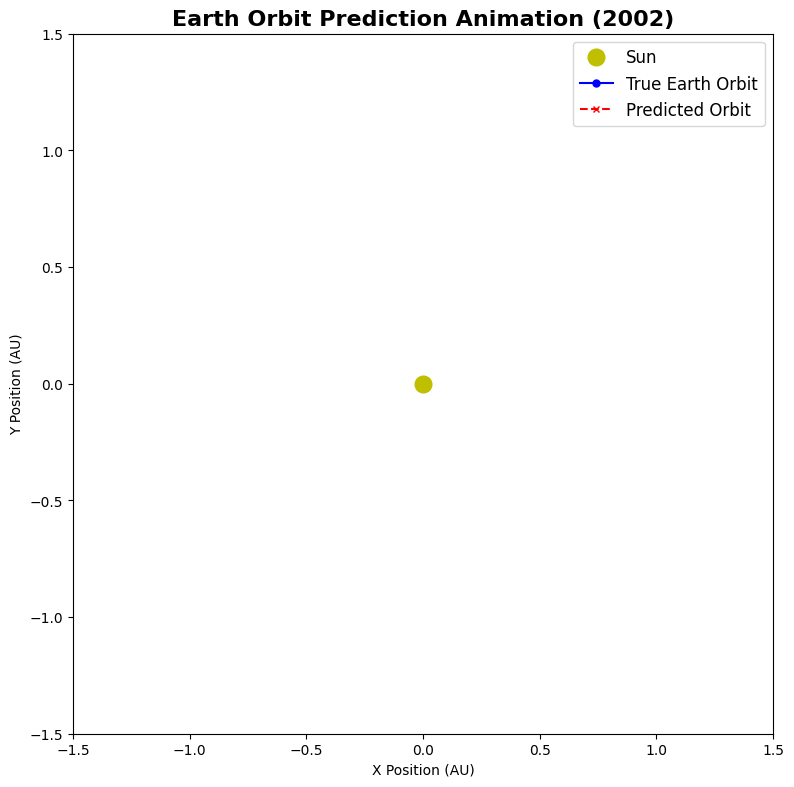

✅ Animation saved as 'earth_orbit_prediction_final.gif'!


In [142]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Set plot limits
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Title and labels
ax.set_title('Earth Orbit Prediction Animation (2002)', fontsize=16, weight='bold')
ax.set_xlabel('X Position (AU)')
ax.set_ylabel('Y Position (AU)')

# Make sure axis are square
ax.set_aspect('equal')

# Initialize artists
sun, = ax.plot(0, 0, 'yo', markersize=12, label='Sun')
true_earth, = ax.plot([], [], 'bo-', markersize=5, label='True Earth Orbit')
predicted_earth, = ax.plot([], [], 'rx--', markersize=5, label='Predicted Orbit')

ax.legend(fontsize=12)

# Initialize function (important for saving!)
def init():
    true_earth.set_data([], [])
    predicted_earth.set_data([], [])
    return true_earth, predicted_earth

# Animate function
def animate(i):
    true_earth.set_data(true_x[:i+1], true_y[:i+1])
    predicted_earth.set_data(predicted_x[:i+1], predicted_y[:i+1])
    return true_earth, predicted_earth

# Number of frames
num_frames = min(len(true_x), len(predicted_x))

# Create animation
ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=num_frames, interval=50, blit=True
)

plt.tight_layout()
plt.show()

# Now saving works properly
ani.save('earth_orbit_prediction_final.gif', writer='pillow', fps=30)
print("✅ Animation saved as 'earth_orbit_prediction_final.gif'!")


In [144]:
# Generate dates for full year
dates = pd.date_range(start='2002-01-01', end='2002-12-31', freq='D')

# Simulate Earth's circular orbit (simplified)
# 1 AU radius, assuming circular for simplicity
# Earth's angular speed: ~2π radians per year (~0.017 radians per day)
days_in_year = 365
theta = np.linspace(0, 2 * np.pi, days_in_year)

earth_x = np.cos(theta)
earth_y = np.sin(theta)

# Create the DataFrame
full_orbit_data = pd.DataFrame({
    'Date': dates,
    'Earth_x': earth_x,
    'Earth_y': earth_y
})

# Display first few rows
full_orbit_data.head()


,Date,Earth_x,Earth_y
0,2002-01-01,1.000000,0.000000
1,2002-01-02,0.999851,0.017261
2,2002-01-03,0.999404,0.034516
3,2002-01-04,0.998659,0.051761
4,2002-01-05,0.997617,0.068991


In [145]:
# Select features
features = full_orbit_data[['Earth_x', 'Earth_y']].values

# Scale features between 0 and 1
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Create sequence function again
def create_sequences(data, sequence_length=30):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Create input/output for the LSTM
X, y = create_sequences(scaled_features)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (335, 30, 2), y shape: (335, 2)


In [146]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense

# Build the model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(2))  # Predicting Earth_x and Earth_y

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X, y, epochs=100, batch_size=32)


Epoch 1/100


c:\Users\edmar\OneDrive\Documents\CSUF\Machine Learning\Solar-System-Dyamics\ofile\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1991 
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0380
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1716e-04
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8208e-04
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6870e-04
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1896e-05
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8235e-05 
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4270e-05
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2452e-05 
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4101e-05
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7812e-05
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
# Predict the entire year
predictions = model.predict(X)

# Inverse transform predictions to original scale
predictions_unscaled = scaler.inverse_transform(predictions)

# Get true Earth orbit positions
true_x = full_orbit_data['Earth_x'].values
true_y = full_orbit_data['Earth_y'].values

# Get predicted Earth orbit positions
predicted_x = predictions_unscaled[:, 0]
predicted_y = predictions_unscaled[:, 1]

# Align lengths (since LSTM loses initial steps)
# We need to drop the first 30 predictions to match the true data length
true_x = true_x[30:]
true_y = true_y[30:]


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


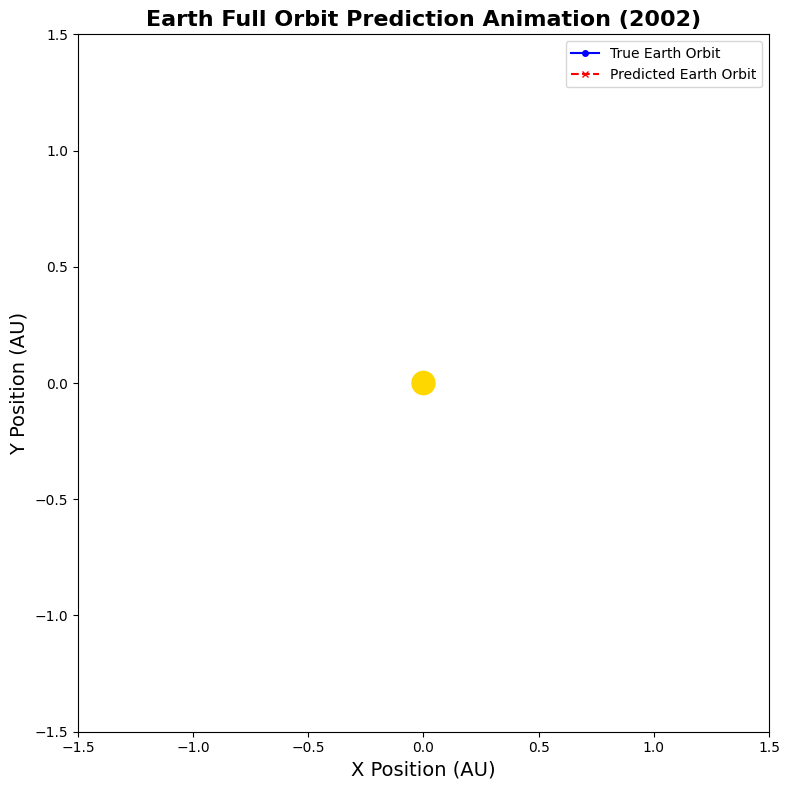

Saved full orbit animation as 'earth_full_orbit_prediction.gif'


In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_title('Earth Full Orbit Prediction Animation (2002)', fontsize=16, weight='bold')
ax.set_xlabel('X Position (AU)', fontsize=14)
ax.set_ylabel('Y Position (AU)', fontsize=14)

# Plot the Sun
sun = plt.Circle((0, 0), 0.05, color='gold')
ax.add_artist(sun)

# Initialize plots
true_line, = ax.plot([], [], 'bo-', markersize=4, label='True Earth Orbit')
predicted_line, = ax.plot([], [], 'rx--', markersize=4, label='Predicted Earth Orbit')
ax.legend()

# Animation function
def animate(i):
    true_line.set_data(true_x[:i], true_y[:i])
    predicted_line.set_data(predicted_x[:i], predicted_y[:i])
    return true_line, predicted_line

# Create animation
num_frames = len(true_x)
ani = animation.FuncAnimation(fig, animate, frames=num_frames, interval=30, blit=True)

plt.tight_layout()
plt.show()

# Optional: save as a GIF
ani.save('earth_full_orbit_prediction.gif', writer='pillow', fps=30)
print("Saved full orbit animation as 'earth_full_orbit_prediction.gif'")


In [155]:
from sklearn.metrics import mean_squared_error

In [ ]:

# Calculate MSE first
mse_x = mean_squared_error(true_x, predicted_x)
mse_y = mean_squared_error(true_y, predicted_y)

# Take the square root manually to get RMSE
rmse_x = np.sqrt(mse_x)
rmse_y = np.sqrt(mse_y)

# Optional combined RMSE
combined_true = np.vstack([true_x, true_y]).T
combined_pred = np.vstack([predicted_x, predicted_y]).T
mse_combined = mean_squared_error(combined_true, combined_pred)
rmse_combined = np.sqrt(mse_combined)

# Print RMSE values
print(f"RMSE for X positions: {rmse_x:.6f} AU")
print(f"RMSE for Y positions: {rmse_y:.6f} AU")
print(f"Combined RMSE: {rmse_combined:.6f} AU")

RMSE for X positions: 0.001947 AU
RMSE for Y positions: 0.003300 AU
Combined RMSE: 0.002710 AU
